<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainPhaseClassifier_04_Spacy_in_command_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 3:
      pages = pages[:3]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [6]:
df_annotations = df_annotations[~df_annotations.phase.isna()]

In [7]:
df_annotations["phase"].value_counts()

Phase 2            4317
Phase 3            2725
Phase 4            1461
Phase 1            1154
Phase 1/Phase 2     983
Not Applicable      519
Phase 2/Phase 3     297
Early Phase 1       135
Name: phase, dtype: int64

In [11]:
df_annotations["phase"].value_counts().max() / df_annotations["phase"].value_counts()

Phase 2             1.000000
Phase 3             1.584220
Phase 4             2.954825
Phase 1             3.740901
Phase 1/Phase 2     4.391658
Not Applicable      8.317919
Phase 2/Phase 3    14.535354
Early Phase 1      31.977778
Name: phase, dtype: float64

In [8]:
labels = sorted(set(df_annotations["phase"]))

# Begin Spacy

In [12]:
import spacy

nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = DocBin()
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for l in labels:
    cats[l] = 0
  
  phase = df_annotations.phase.iloc[idx]
  cats[phase] = 1
  doc.cats = cats

  # data augmenting
  aug = 1
  if  df_annotations.train_val.iloc[idx] == "train" and phase not in ("Phase 2", "Phase 3" ):
    aug = 2
  for i in range(aug):
    docs_list.add(doc)  

0 11591
100 11591
200 11591
300 11591
400 11591
500 11591
600 11591
700 11591
800 11591
900 11591
1000 11591
1100 11591
1200 11591
1300 11591
1400 11591
1500 11591
1600 11591
1700 11591
1800 11591
1900 11591
2000 11591
2100 11591
2200 11591
2300 11591
2400 11591
2500 11591
2600 11591
2700 11591
2800 11591
2900 11591
3000 11591
3100 11591
3200 11591
3300 11591
3400 11591
3500 11591
3600 11591
3700 11591
3800 11591
3900 11591
4000 11591
4100 11591
4200 11591
4300 11591
4400 11591
4500 11591
4600 11591
4700 11591
4800 11591
4900 11591
5000 11591
5100 11591
5200 11591
5300 11591
5400 11591
5500 11591
5600 11591
5700 11591
5800 11591
5900 11591
6000 11591
6100 11591
6200 11591
6300 11591
6400 11591
6500 11591
6600 11591
6700 11591
6800 11591
6900 11591
7000 11591
7100 11591
7200 11591
7300 11591
7400 11591
7500 11591
7600 11591
7700 11591
7800 11591
7900 11591
8000 11591
8100 11591
8200 11591
8300 11591
8400 11591
8500 11591
8600 11591
8700 11591
8800 11591
8900 11591
9000 11591
9100 11591


In [13]:
docs_val.to_disk("/content/drive/MyDrive/data/dev_phase_04.spacy")
docs_train.to_disk("/content/drive/MyDrive/data/train_phase_04.spacy")

# for idx, doc_bin_train in enumerate(docs_train):
#   doc_bin_train.to_disk(f"/content/drive/MyDrive/data/train_is_international.spacy/train_doc_bin{idx}.spacy")

In [14]:
# !python -m spacy init fill-config base_config.cfg spacy_textcat_is_international_11.cfg

In [18]:
!python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_textcat_phase_04 --paths.train /content/drive/MyDrive/data/train_phase_04.spacy --paths.dev /content/drive/MyDrive/data/dev_phase_04.spacy --gpu-id 0

✔ Created output directory:
/content/drive/MyDrive/data/output_textcat_phase_04
ℹ Saving to output directory:
/content/drive/MyDrive/data/output_textcat_phase_04
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-17 14:01:12,663] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-17 14:01:12,673] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-17 14:01:12,677] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-17 14:01:12,678] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
tcmalloc: large alloc 1073750016 bytes == 0xbae26000 @  0x7f78e232f2a4 0x58ead6 0x441ff3 0x5d1f81 0x5d2306 0x58f62c 0x5105e2 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x4d01b4 0x50cb8d 0x4d01b4 0x50cb8d 0x4d01b4 0x7f778ccf47c6 0x4ba72b 0x7f778ccf2ce3 0x58f6e4 0x50ff13 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x58ff2e 0x50d482 0x5b575e 0x58ff2e
tcmallo

In [19]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_textcat_phase_04/model-best")

In [21]:
df_val = df_annotations[df_annotations.train_val=="val"]

In [22]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [24]:
df_val["y_pred_phase"] = [max(p, key=p.get) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
pred_phase = df_val["y_pred_phase"]

In [26]:
acc = accuracy_score(df_val.phase, df_val["y_pred_phase"])
print (f"Phase accuracy {acc}")

Phase accuracy 0.5298013245033113


''

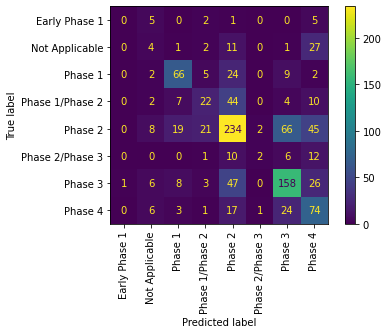

In [27]:
ConfusionMatrixDisplay.from_predictions(df_val.phase, df_val["y_pred_phase"])
plt.xticks(rotation=90)
;

In [28]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for phase in labels:
  roc_auc = roc_auc_score(df_val.phase == phase, [p[phase] for p in predictions])
  print (f"Phase ROC AUC {roc_auc} for {phase}")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Phase ROC AUC 0.6317418213969939 for Early Phase 1
Phase ROC AUC 0.7959833139809918 for Not Applicable
Phase ROC AUC 0.8760439839206962 for Phase 1
Phase ROC AUC 0.7666624106230848 for Phase 1/Phase 2
Phase ROC AUC 0.7668323836475582 for Phase 2
Phase ROC AUC 0.700685405269446 for Phase 2/Phase 3
Phase ROC AUC 0.8337558153405703 for Phase 3
Phase ROC AUC 0.8360186179735053 for Phase 4
Average 0.7759654690191058


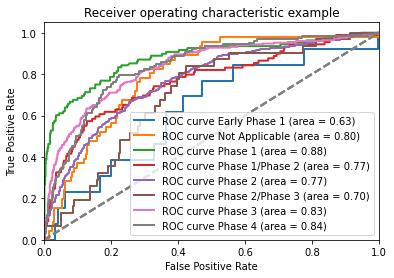

In [29]:
plt.figure()
lw = 2
    
for phase in labels:
    fpr, tpr, _ = roc_curve(df_val.phase == phase, [p[phase] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {phase} (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()